In [31]:
import os, cv2, glob, math, time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

## For visualization
import pylab as pl
from IPython import display

from sklearn.neighbors import KDTree
import random


In [349]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

## Dataset

In [33]:
datapath  = "/home/penguin2/SonarDescriptor/training_set/flyingGHR_20m/data"
datapath2 = "/home/penguin2/SonarDescriptor/validation/flyingGHR_20m/data"

In [34]:
class Pose:
    def __init__(self, label_path):
        with open(label_path, "r") as file:
            xyz = file.readline()[:-1].split()
            self.x, self.y, self.z = float(xyz[0]), float(xyz[1]), float(xyz[2])
            quat = file.readline().split()
            self.q0, self.q1, self.q2, self.q3 = float(quat[0]), float(quat[1]), float(quat[2]), float(quat[3])
            r = R.from_quat([self.q0, self.q1, self.q2, self.q3])
            self.r, self.p, self.yaw = r.as_euler('xyz', degrees=True)
            self.r = 0
            self.p = 0
    def __call__(self):
        return torch.Tensor([self.x, self.y, self.yaw])

In [208]:
class SonarDescriptorDatasetFull(Dataset):
    def __init__(self, datapath, database4val=None):
        self.img_source = glob.glob(os.path.join(datapath, "imgs", "*"))
        self.img_labels = glob.glob(os.path.join(datapath, "poses", "*"))

        self.img_source.sort()
        self.img_labels.sort()
        self.img_source = np.array(self.img_source)
        self.img_labels = np.array(self.img_labels)

        self.training = database4val is None

        if self.training:
            self.realimg_source = glob.glob("/home/penguin2/SonarDescriptor/training_set/placerec_trieste/imgs/*")
            self.realimg_source.sort()
            self.realimg_source = np.array(self.realimg_source)[:1700]
            self.imgs = np.concatenate((self.img_source, self.realimg_source))
            
            self.descriptors=[]

            self.angles_shifts = np.array([-30, 0, 30]) ## degrees
            self.shifts = []
            
            for i in range(len(self.angles_shifts)):
                self.shifts.append(round(self.angles_shifts[i]*1536/360))
    
            self.shifts = np.array(self.shifts)
            print("self.angles_shifts", self.angles_shifts)
            print("self.shifts", self.shifts)
            
            self.poses = np.zeros((len(self.img_source)+len(self.realimg_source), 3))
            self.augm_poses = np.zeros((len(self.img_source)*len(self.shifts)+len(self.realimg_source), 3))
            self.apply_random_rot = False
            
        else:
            self.poses = np.zeros((len(self.img_source), 3))
            self.imgs = self.img_source
            self.apply_random_rot = True

        
        self.synth = len(self.img_source)

        if not self.training:
            self.rotations = np.zeros(len(self.img_labels))
        
        cont=0
        for i in range(len(self.img_labels)):
            lab_path = self.img_labels[i]
            pose = Pose(lab_path)()
            if self.training:
                self.poses[i] = pose
                for shift_idx in range(len(self.shifts)):
                    pose_ = np.copy(pose)
                    #self.poses[i] = pose
                    pose_[2]+=self.angles_shifts[shift_idx]
                    self.augm_poses[cont] = pose_
                    cont += 1
            else:
                if self.apply_random_rot:
                    random_rotation = random.uniform(0, 1)*120 - 60 ## random rotation of +60 / -60 deg
                    #print("random_rotation",random_rotation)
                    pose[2] = pose[2] + random_rotation
                    self.rotations[i] = random_rotation
                self.poses[i] = pose

        self.pad = nn.ZeroPad2d((0, 0, 18, 18))
        self.img_size = (256, 220)
        self.min_dx, self.min_dy = 335, -458
        self.poses[:self.synth, 0]-=self.min_dx
        self.poses[:self.synth, 1]-=self.min_dy
        self.poses[:self.synth, :2]*=10

        if self.training:
            self.augm_poses[:, 0]-=self.min_dx
            self.augm_poses[:, 1]-=self.min_dy
            self.augm_poses[:, :2]*=10
        
        self.poses = torch.Tensor(self.poses)
        if self.training:
            self.augm_poses = torch.Tensor(self.augm_poses)
        else:
            self.closest_poses = self.correlate_poses(database4val)
            
        
    def __len__(self):
        return len(self.imgs)

    def computeDescriptors(self, net):
        self.descriptors=[]
        print("computing dataset descriptors")
        net.eval()
        if not self.training:
            self.shifts=np.array([0])
        with torch.no_grad():
            for idx in tqdm(range(len(self.img_labels))):
                img_path = self.imgs[idx//len(self.shifts)]
                image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
                for i in range(len(self.shifts)):
                    shift = self.shifts[i]
                    image_ = np.copy(image[:, (512-shift):(1024-shift)])
                    image_ = cv2.resize(image_, self.img_size)
                    image_ = self.pad(torch.Tensor(image_))
                    image_ = ( image_ / 255.0 ) - 0.5
                    image_ = image_[None] * np.pi
                    sin, cos = torch.sin(image_), torch.cos(image_)
                    image_ = torch.cat([sin, cos]).cuda()[None]
                    descriptor = net(image_, reco=False)[0, :].detach().cpu().numpy()
                    self.descriptors.append(descriptor)
        print("descriptors computed!")

    def correlate_poses(self, database4val):
        self.closest_indices = np.zeros(self.poses.shape[0])
        for idx in range(self.poses.shape[0]):
            self.closest_indices[idx] = database4val.gtquery(self.poses[idx])
        self.closest_indices = self.closest_indices.astype(int)

    def gtquery(self, testpose):
        x,y,yaw = testpose
        dist_matrix = torch.cdist(torch.Tensor([x,y]).unsqueeze(0), self.poses[:self.synth, :2].unsqueeze(0)).squeeze()  # Shape: (N, M)
        closest_index = torch.argmin(dist_matrix, dim=-1)
        # print("XY distance:", math.sqrt((x-self.poses[closest_index, 0])**2 + (y-self.poses[closest_index, 1])**2), closest_index.item())

        base_offset = closest_index*len(self.shifts)
        shifts = self.augm_poses[base_offset:base_offset+len(self.shifts), 2]
        
        yawdiff = np.abs(shifts - yaw.item())
        # print("closest rotation shift:", np.argmin(yawdiff), self.angles_shifts[np.argmin(yawdiff)])
        closest_index = closest_index*len(self.shifts)+np.argmin(yawdiff)
        
        return closest_index
   
    def query(self, query_descriptor):
        self.norms = np.zeros(len(self.descriptors))
        for i in range(len(self.descriptors)):
            self.norms[i] = np.linalg.norm(self.descriptors[i] - query_descriptor, ord=2)
        return self.norms.argmin()

    def __getitem__(self, idx):
        
        img_path = self.imgs[idx]

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
       
        if not self.training:
            pose = np.copy(self.poses[idx])
        else:
            if self.apply_random_rot:
                pose = np.copy(self.poses[idx])
            else:
                pose = np.copy(self.augm_poses[idx])
        
        if self.training:
            random_rotation = 0
            if self.apply_random_rot:
                if idx<self.synth:
                    random_rotation = random.uniform(0, 1)*120 - 60 ## random rotation of +60 / -60 deg
                    # print("random_rotation",random_rotation)
                    pose[2] = pose[2] + random_rotation
                    shift = int(1536*random_rotation / 360)
                    image = image[:, (512-shift):(1024-shift)]
                    image = cv2.resize(image, self.img_size)

            else:
                rotation = self.angles_shifts[idx % len(self.shifts)]
                shift = int(1536*rotation / 360)
                image = image[:, (512-shift):(1024-shift)]
                image = cv2.resize(image, self.img_size)
        else:
            rotation = self.rotations[idx]
            shift = int(1536*rotation / 360)
            image = image[:, (512-shift):(1024-shift)]
            image = cv2.resize(image, self.img_size)
            
            # if idx < self.synth:
            #     random_rotation=0
            #     if self.apply_random_rot:
            #         random_rotation = random.uniform(0, 1)*120 - 60 ## random rotation of +60 / -60 deg
            #         # print("random_rotation",random_rotation)
            #         pose[2] = pose[2] + random_rotation
            #     else:
            #         random_rotation = self.angles_shifts[idx % len(self.shifts)]
            #     # if self.training:
            #     #     random_rotation = self.angles_shifts[idx % len(self.shifts)]
            #     shift = int(1536*random_rotation / 360)
            #     image = image[:, (512-shift):(1024-shift)]
            #     image = cv2.resize(image, self.img_size)

        image = self.pad(torch.Tensor(image))
        image = ( image / 255.0 ) - 0.5
        image_ = image[None] * np.pi #- 0.5
        # print(idx, img_path, image.shape)

        sin, cos = torch.sin(image_), torch.cos(image_)

        return torch.cat([sin, cos]), torch.Tensor(image)[None], pose, img_path, self.img_labels[idx] if idx<self.synth else "aaa", 1 if idx<self.synth else 0

In [36]:
# class SonarDescriptorDatabase():
#     def __init__(self, datapath):
        
#         self.img_source = glob.glob(os.path.join(datapath, "imgs", "*"))
#         self.img_labels = glob.glob(os.path.join(datapath, "poses", "*"))

#         self.img_source.sort()
#         self.img_labels.sort()
#         self.img_source = np.array(self.img_source)
#         self.img_labels = np.array(self.img_labels)
#         self.imgs = self.img_source
        
#         # self.shifts = [-48, -40, -32, -24, -16, -8, 0, 8, 16, 24, 32, 40, 48]
#         # self.shifts = [-32, 0, 32]
#         # self.angles_shifts = []
#         self.angles_shifts = np.array([-30, 0, 30]) ## degrees
#         self.shifts = []
        
#         for i in range(len(self.angles_shifts)):
#             self.shifts.append(round(self.angles_shifts[i]*1536/360))

#         self.shifts = np.array(self.shifts)

#         print("self.angles_shifts", self.angles_shifts)
#         print("self.shifts", self.shifts)
       
#         self.poses = np.zeros((len(self.img_source), 3))
#         self.augm_poses = np.zeros((len(self.img_source)*len(self.shifts), 3))
        
#         cont = 0
#         for idx in range(len(self.img_labels)):
            
#             lab_path = self.img_labels[idx]
#             pose = Pose(lab_path)()

#             for i in range(len(self.shifts)):
#                 pose = np.copy(pose)
#                 self.poses[idx] = pose
#                 pose[2]+=self.angles_shifts[i]
#                 self.augm_poses[cont] = pose
#                 cont += 1
            
#         self.poses = torch.Tensor(self.poses)
#         self.augm_poses = torch.Tensor(self.augm_poses)

#         min_dx, min_dy = 335, -458
#         self.poses[:, 0]-=min_dx
#         self.poses[:, 1]-=min_dy
#         self.poses[:, :2]*=10

#         self.pad = nn.ZeroPad2d((0, 0, 18, 18))
#         self.img_size = (256, 220)
        
#     def __len__(self):
#         return len(self.poses)

#     def computeDescriptors(self, net):
#         self.descriptors=[]
#         print("computing dataset descriptors")
#         net.eval()
#         with torch.no_grad():
#             for idx in tqdm(range(len(self.img_labels))):
#                 img_path = self.imgs[idx]
#                 image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
#                 for i in range(len(self.shifts)):
#                     shift = self.shifts[i]
#                     image_ = np.copy(image[:, (512-shift):(1024-shift)])
#                     image_ = cv2.resize(image_, self.img_size)
#                     image_ = self.pad(torch.Tensor(image_))
#                     image_ = ( image_ / 255.0 ) - 0.5
#                     image_ = image_[None] * np.pi
#                     sin, cos = torch.sin(image_), torch.cos(image_)
#                     image_ = torch.cat([sin, cos]).cuda()[None]
#                     descriptor = net(image_, reco=False)[0, :].detach().cpu().numpy()
#                     self.descriptors.append(descriptor)
#         print("descriptors computed!")
   
#     def gtquery(self, testpose):
#         x,y,yaw = testpose
#         dist_matrix = torch.cdist(torch.Tensor([x,y]).unsqueeze(0), self.poses[:, :2].unsqueeze(0)).squeeze()  # Shape: (N, M)
#         print(dist_matrix.shape)
#         closest_index = torch.argmin(dist_matrix, dim=-1)
#         print("XY distance:", math.sqrt((x-self.poses[closest_index, 0])**2 + (y-self.poses[closest_index, 1])**2))

#         yawdiff = np.abs(np.shifts - yaw)
#         closest_index = closest_index*len(self.shifts)+np.argmin(yawdiff)
        
#         return closest_index
   
#     def query(self, query_descriptor):
#         self.norms = np.zeros(len(self.descriptors))
#         for i in range(len(self.descriptors)):
#             self.norms[i] = np.linalg.norm(self.descriptors[i] - query_descriptor, ord=2)
#         self.minidx = self.norms.argmin()
#         return self.minidx, self.dataset[self.minidx]

In [209]:
train_data = SonarDescriptorDatasetFull(datapath, None)
val_data = SonarDescriptorDatasetFull(datapath2, train_data)

self.angles_shifts [-30   0  30]
self.shifts [-128    0  128]


In [130]:
descs = torch.Tensor(train_data.descriptors).clone()

3 /home/penguin2/SonarDescriptor/validation/flyingGHR_20m/data/imgs/100.jpeg
-26.990579769728228


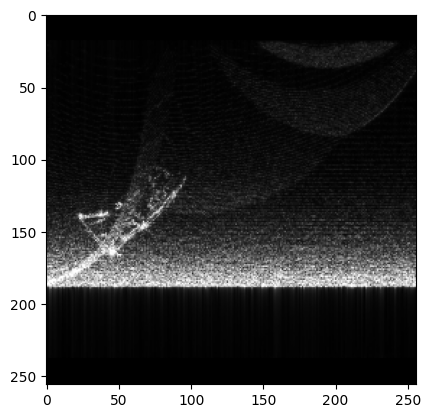

In [195]:
query_idx = 3
query_input_image, query_real_image, query_gtpose, query_img_path, query_pose_path, _ = val_data[query_idx]
print(val_data.rotations[query_idx])
plt.imshow(query_real_image.detach().cpu().numpy()[0, :, :], cmap='gray')


In [131]:
train_data.descriptors = descs

In [263]:
train_data.computeDescriptors(net)
val_data.computeDescriptors(net)

computing dataset descriptors


 48%|██████████████████▋                    | 1756/3654 [01:27<01:35, 19.97it/s]


KeyboardInterrupt: 

253 /home/penguin2/SonarDescriptor/validation/flyingGHR_20m/data/imgs/326.jpeg
107.309875 124.70001 79.51994
2966 /home/penguin2/SonarDescriptor/training_set/flyingGHR_20m/data/imgs/38.jpeg
closest_idx: 2966
106.67999 124.44 61.014454
DIFFERENCE 18.505489349365234
1.9739773305571733 iou: 0.8387139919397164
localization error:  0.06814377903938293 meters


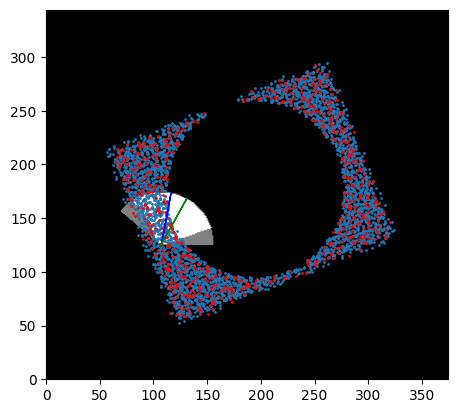

In [176]:
plt.scatter(train_data.poses[:train_data.synth, 0], train_data.poses[:train_data.synth, 1], marker='o', linestyle='None', s = 1)
plt.scatter(val_data.poses[:, 0], val_data.poses[:, 1], c='red', marker='o', linestyle='None', s = 1)

ax = plt.gca()
ax.set_xlim([0, train_data.poses[:train_data.synth, 0].max()+50])
ax.set_ylim([0, train_data.poses[:train_data.synth, 1].max()+50])
rad = 50

query_idx = np.random.randint(len(val_data), size=1)[0]
val_query = val_data[query_idx][2]

x,y,Y1_deg = np.array(val_query, copy=True)#train_data.poses[minidx, :3].clone()
print(x,y,Y1_deg)
Y1_deg = 90 - Y1_deg
Y1 = Y1_deg * math.pi / 180
dy, dx = rad*math.cos(Y1), rad*math.sin(Y1)
plt.arrow(x, y, dx, dy, color='blue')

center = np.array([x, y]).astype(int)
mask1 = sector_mask((325+50, 295+50),center,50,(Y1_deg-60,Y1_deg+60)).T
# plt.imshow(mask1, cmap="gray")


closest_idx = val_data.closest_indices[query_idx] #train_data.gtquery(val_query)
train_closest = train_data[closest_idx][2]

print("closest_idx:", closest_idx)
x,y,Y2_deg = train_closest
print(x,y,Y2_deg)
Y2_deg = 90 - Y2_deg
Y2 = Y2_deg * math.pi / 180
dy, dx = rad*math.cos(Y2), rad*math.sin(Y2)
plt.arrow(x, y, dx, dy, color='green')

print("DIFFERENCE", abs(Y2_deg-Y1_deg))

center = np.array([x, y]).astype(int)
mask2 = sector_mask((325+50, 295+50),center,50,(Y2_deg-60,Y2_deg+60)).T
# plt.imshow(mask2, cmap="gray")

##### INTERFERENCE
mask_and = np.logical_and(mask1, mask2) ## intersection
mask_xor = np.logical_xor(mask1, mask2) ## U/intersection 

R3 = 2*abs(math.cos((Y1-Y2)/2))
mask_and = mask_and*R3

mask3 = mask_and + mask_xor

union = mask1.sum() + mask2.sum()
intersection = mask_and.sum()
iou = intersection/union if union>0 else 0

print(mask_and.max(), "iou:", iou)

plt.imshow(mask3, cmap="gray")
    
print("localization error: ", np.linalg.norm(train_closest[:2]-val_query[:2], ord=2)/10, "meters")

In [62]:
train_data.computeDescriptors(net)

computing dataset descriptors


 29%|██████████▉                           | 3654/12662 [02:51<07:02, 21.35it/s]

descriptors computed!


In [41]:
# min_dx, min_dy = 335, -458
# train_data.poses[:train_data.synth, 0]-=min_dx
# train_data.poses[:train_data.synth, 1]-=min_dy
# val_data.poses[:, 0]                  -=min_dx
# val_data.poses[:, 1]                  -=min_dy
# train_data.poses[:train_data.synth, :2]*=10
# val_data.poses[:, :2]*=10

In [348]:
batch = 20
k = batch * (batch-1)

train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Common utilities

In [43]:
def save_state(epoch, model, path):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            }, path)
def load_state(model, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    return model


### Model definition

In [44]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, \
            f"img_size {img_size} should be divided by patch_size {patch_size}."
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape

        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        H, W = H // self.patch_size[0], W // self.patch_size[1]

        return x, (H, W)


class PyramidVisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm, depths=[3, 4, 6, 3],
                 sr_ratios=[8, 4, 2, 1], num_stages=4, F4=False):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths
        self.F4 = F4
        self.num_stages = num_stages

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0

        for i in range(num_stages):
            patch_embed = PatchEmbed(img_size=img_size if i == 0 else img_size // (2 ** (i + 1)),
                                     patch_size=patch_size if i == 0 else 2,
                                     in_chans=in_chans if i == 0 else embed_dims[i - 1],
                                     embed_dim=embed_dims[i])
            num_patches = patch_embed.num_patches if i != num_stages - 1 else patch_embed.num_patches + 1
            pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dims[i]))
            pos_drop = nn.Dropout(p=drop_rate)

            block = nn.ModuleList([Block(
                dim=embed_dims[i], num_heads=num_heads[i], mlp_ratio=mlp_ratios[i], qkv_bias=qkv_bias,
                qk_scale=qk_scale, drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + j],
                norm_layer=norm_layer, sr_ratio=sr_ratios[i])
                for j in range(depths[i])])
            cur += depths[i]

            setattr(self, f"patch_embed{i + 1}", patch_embed)
            setattr(self, f"pos_embed{i + 1}", pos_embed)
            setattr(self, f"pos_drop{i + 1}", pos_drop)
            setattr(self, f"block{i + 1}", block)

            trunc_normal_(pos_embed, std=.02)

        # init weights
        self.apply(self._init_weights)

    def init_weights(self, pretrained=None):
        if isinstance(pretrained, str):
            logger = get_root_logger()
            load_checkpoint(self, pretrained, map_location='cpu', strict=False, logger=logger)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def _get_pos_embed(self, pos_embed, patch_embed, H, W):
        if H * W == self.patch_embed1.num_patches:
            return pos_embed
        else:
            return F.interpolate(
                pos_embed.reshape(1, patch_embed.H, patch_embed.W, -1).permute(0, 3, 1, 2),
                size=(H, W), mode="bilinear").reshape(1, -1, H * W).permute(0, 2, 1)

    def forward_features(self, x):
        outs = []

        B = x.shape[0]

        for i in range(self.num_stages):
            patch_embed = getattr(self, f"patch_embed{i + 1}")
            pos_embed = getattr(self, f"pos_embed{i + 1}")
            pos_drop = getattr(self, f"pos_drop{i + 1}")
            block = getattr(self, f"block{i + 1}")
            x, (H, W) = patch_embed(x)
            if i == self.num_stages - 1:
                pos_embed = self._get_pos_embed(pos_embed[:, 1:], patch_embed, H, W)
            else:
                pos_embed = self._get_pos_embed(pos_embed, patch_embed, H, W)

            x = pos_drop(x + pos_embed)
            for blk in block:
                x = blk(x, H, W)
            x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
            outs.append(x)

        return outs

    def forward(self, x):
        x = self.forward_features(x)

        if self.F4:
            x = x[3:4]

        return x


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v

    return out_dict

In [45]:
class MLP(nn.Module):
    """
    Linear Embedding
    """
    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)
        self.norm = nn.BatchNorm1d(64)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        x = self.proj(x)
        x = self.act(x)
        return x


class SegFormerHead2(nn.Module):
    """
    SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers
    """
    def __init__(self, embedding_dim=128, in_channels_head=[32, 64, 128, 256], num_classes=1, img_size=512):
        super().__init__()
        self.img_size = img_size
        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = in_channels_head

        # self.linear_c4 = MLP(input_dim=c4_in_channels, embed_dim=embedding_dim)
        # self.linear_c3 = MLP(input_dim=c3_in_channels, embed_dim=embedding_dim)
        # self.linear_c2 = MLP(input_dim=c2_in_channels, embed_dim=embedding_dim)
        # self.linear_c1 = MLP(input_dim=c1_in_channels, embed_dim=embedding_dim)

        self.linear_fuse = nn.Sequential(
            nn.Conv2d(in_channels=embedding_dim*4, out_channels=embedding_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(num_features=embedding_dim),
            nn.ReLU(inplace=True)
        )

        self.linear_pred = nn.Conv2d(embedding_dim, num_classes, kernel_size=1)
        self.linear_pred_1 = nn.Conv2d(embedding_dim, num_classes, kernel_size=1)
        self.linear_pred_2 = nn.Conv2d(embedding_dim, num_classes, kernel_size=1)
        self.linear_pred_3 = nn.Conv2d(embedding_dim, num_classes, kernel_size=1)
        self.linear_pred_4 = nn.Conv2d(embedding_dim, num_classes, kernel_size=1)
        
        self.linear_c4 = nn.ConvTranspose2d(c4_in_channels, embedding_dim, kernel_size=32, stride=32)
        self.linear_c3 = nn.ConvTranspose2d(c3_in_channels, embedding_dim, kernel_size=16, stride=16)
        self.linear_c2 = nn.ConvTranspose2d(c2_in_channels, embedding_dim, kernel_size=8, stride=8)
        self.linear_c1 = nn.ConvTranspose2d(c1_in_channels, embedding_dim, kernel_size=4, stride=4)
        

    def forward(self, inputs):
        c1, c2, c3, c4 = inputs

        ############## MLP decoder on C1-C4 ###########
        n, _, h, w = c4.shape

        _c4 = self.linear_c4(c4)#.reshape(n, -1, c4.shape[2], c4.shape[3])
        # print("c4", c4.shape, "_c4", _c4.shape)
        _c3 = self.linear_c3(c3)#.reshape(n, -1, c3.shape[2], c3.shape[3])
        # print("c3", c3.shape, "_c3", _c3.shape)
        _c2 = self.linear_c2(c2)#.reshape(n, -1, c2.shape[2], c2.shape[3])
        # print("c2", c2.shape, "_c2", _c2.shape)
        _c1 = self.linear_c1(c1)#.reshape(n, -1, c1.shape[2], c1.shape[3])
        # print("c1", c1.shape, "_c1", _c1.shape)
        x = self.linear_fuse(torch.cat([_c4, _c3, _c2, _c1], dim=1))

        _c4 = self.linear_pred_4(_c4)
        _c3 = self.linear_pred_3(_c3)
        _c2 = self.linear_pred_2(_c2)
        _c1 = self.linear_pred_1(_c1)
        x   = self.linear_pred(x)

        return [x , _c1, _c2, _c3, _c4]

In [303]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        channels = [16, 32, 64, 128]
        self.encoder = PyramidVisionTransformer(in_chans=2, img_size=256, sr_ratios=[8, 4, 2, 1], patch_size=4, embed_dims=channels)
        self.embed = MLP(16*8, 4)
        self.decoder = SegFormerHead2(in_channels_head=channels, img_size=256, num_classes=1)
        
    def forward(self, x, reco=False):
        out = self.encoder(x)
        embed = torch.nn.functional.normalize(self.embed(out[-1]).flatten(1), p=2, dim=1)
        if reco:
            rec = self.decoder(out)
            return embed, rec
            
        return embed

### Model instantiation

In [350]:
net = Model().cuda()
# net = load_state(net, "/home/penguin2/SonarDescriptor/titan_models_1/epoch_03.pth")
net.train()

optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.85)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(train_data)//2, 1, eta_min=1e-4)#(optimizer, base_lr=0.01, max_lr=0.1)

drop = torch.nn.Dropout(0.3).cuda()

In [203]:
criterion = torch.nn.L1Loss().cuda()

### Learning Rate Visualization

In [49]:

# lr = []
# for epoch in range(15):
#     for i in range(len(train_data)):
#         lr.append(scheduler.get_lr())
#         scheduler.step()

# plt.plot(np.arange(0, len(train_data)*15, 1), np.array(lr))

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.85)

## Training Pipeline

### Utils for metrics computation

#### Loss-function related

In [327]:
# def euclidean_distance_matrix(poses):
#     # Expand dims to enable broadcasting
#     poses = poses[:, :2].unsqueeze(1)  # Shape: (2, 1, N)

#     # Compute differences along the first axis (X and Y coordinates)
#     diff = poses - poses.permute(1, 0, 2)  # Shape: (N, N, 2)

#     # Compute squared distances
#     squared_dist = torch.sum(diff ** 2, dim=2)  # Shape: (N, N)

#     # Compute Euclidean distances
#     # euclidean_dist = torch.sqrt(squared_dist)

#     return squared_dist #euclidean_dist

In [351]:
def calcEmbedMatrix(vectors):
    # Compute differences between vectors
    diff = vectors.unsqueeze(1) - vectors.unsqueeze(0)  # Shape: (N, N, C)

    # Compute squared distances
    squared_dist = torch.sum(diff ** 2, dim=2)  # Shape: (N, N)
    squared_dist = torch.clamp(squared_dist, 1e-8, squared_dist.max().item()) ### the derivative at sqrt(0) is infinity!!! must clamp
    return torch.sqrt(squared_dist) #euclidean_dist

In [52]:
def sector_mask(shape,centre,radius,angle_range):
    """
    Return a boolean mask for a circular sector. The start/stop angles in  
    `angle_range` should be given in clockwise order.
    """

    x,y = np.ogrid[:shape[0],:shape[1]]
    cx,cy = centre
    tmin,tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)

    # circular mask
    circmask = r2 <= radius*radius

    # angular mask
    anglemask = theta <= (tmax-tmin)

    return (circmask*anglemask).astype(int)

In [352]:
def generate_sonar_map(pose, flag):
    rad = 150
    if not flag:
        # return np.zeros((325, 295)).T
        return np.zeros((325+rad*2, 295+rad*2)).T
    x,y,Y_deg = pose[:3].clone()
    x+=rad
    y+=rad
    Y_deg = 90 - Y_deg
    Y_deg = 90 - Y_deg
    center = np.array([x, y]).astype(int)
    # mask = sector_mask((325, 295),center,rad,(Y_deg-60,Y_deg+60)).T
    mask = sector_mask((325+rad*2, 295+rad*2),center,rad,(Y_deg-60,Y_deg+60)).T
    return mask

def sonar_overlap_distance_matrix(gtposes, mode):
    iou_matrix = np.zeros((gtposes.shape[0], gtposes.shape[0]))
    sonar_images = [generate_sonar_map(gtposes[i], mode[i]) for i in range(gtposes.shape[0])]

    # f, axarr = plt.subplots(len(sonar_images), 1, figsize=(15, 15))
    # for i in range(len(sonar_images)):
    #     axarr[i].set_title("mode:"+str(mode[i]))
    #     axarr[i].imshow(sonar_images[i], cmap="gray")


    for i in range(gtposes.shape[0]):
        for j in range(i+1, gtposes.shape[0]):
            ##### INTERFERENCE
            mask_and = np.logical_and(sonar_images[i], sonar_images[j]) ## intersection
            mask_xor = np.logical_xor(sonar_images[i], sonar_images[j]) ## U/intersection
            Y1 = (90-gtposes[i][2])*np.pi/180
            Y2 = (90-gtposes[j][2])*np.pi/180
            
            R3 = 2*abs(math.cos((Y1-Y2)/2))
            mask_and = mask_and*R3
            
            mask3 = mask_and + mask_xor
            
            union = sonar_images[i].sum() + sonar_images[j].sum()
            intersection = mask_and.sum()
            iou = intersection/union if union >0 else 0
            iou_matrix[i][j] = iou

    iou_matrix = np.maximum( iou_matrix, iou_matrix.transpose() )
    np.fill_diagonal(iou_matrix, 1.0)
    return torch.Tensor(1-iou_matrix)

#### Performance measurement related

In [54]:
# def correlate_poses(matrix1, matrix2):
#     # Compute Euclidean distance between each pair of poses
#     dist_matrix = torch.cdist(matrix1, matrix2)  # Shape: (N, M)

#     # Find the index of the closest pose in matrix2 for each pose in matrix1
#     closest_indices = torch.argmin(dist_matrix, dim=1)

#     return closest_indices

In [55]:
def correlate_poses_topk(matrix1, matrix2, k=1):
    # Compute Euclidean distance between each pair of poses
    dist_matrix = torch.cdist(matrix1, matrix2)  # Shape: (N, M)

    # Find the index of the closest pose in matrix2 for each pose in matrix1
    closest_indices = torch.argsort(dist_matrix, dim=1)[:, :k]

    return closest_indices

In [114]:
def computeAverageMetricError(pred_indices, gt_indices, train_data, k=1):
    prp = train_data.augm_poses[pred_indices, :2]   ## pred_retrieved_poses
    grp = train_data.augm_poses[gt_indices, :2]     ## gt_retrieved_poses
    # print("prp", prp.shape, "grp", grp.shape)
    if k==1:
        diff = prp.unsqueeze(1) - grp.unsqueeze(1)
    else:
        # print(grp.unsqueeze(1).expand((-1, k, 2).shape))
        diff = prp - grp.unsqueeze(1).expand((-1, k, 2))
    
    squared_dist = torch.sqrt(torch.sum(diff ** 2, dim=2))
    # print(squared_dist.max())

    if k>1:
        squared_dist = torch.min(squared_dist, dim=1)[0]
    
    return squared_dist.mean()

### Train epochs

In [353]:
for epoch in range(0, 15):

    ## train
    train_data.apply_random_rot = True
    net.train()

    for idx, (image, gtimage, gtpose, _, _, mode) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        image = drop(image.cuda())
        gtimage = gtimage.cuda()
        mode = mode[:, None].cuda()
        
        embed, rec = net(image, reco=True)

        # distmat  = torch.clamp(euclidean_distance_matrix(gtpose), 0, 2).cuda()
        distmat  = torch.clamp(sonar_overlap_distance_matrix(gtpose, mode), 1e-4, 1).cuda()
        # embedmat = calcEmbedMatrix(embed) #torch.clamp(calcEmbedMatrix(embed), 0, 1)
        embedmat = torch.clamp(calcEmbedMatrix(embed), 0, 1)

        # print(embed)
        # print(distmat)
        # print(embedmat)
        # print()

        distmat = mode*distmat
        embedmat  = mode*embedmat
        # print(distmat)
        # print(embedmat)
        # print()
        
        
        loss_reco = criterion(rec[0], gtimage) + 0.125*criterion(rec[3], gtimage) + 0.25*criterion(rec[4], gtimage)
        loss_loca = criterion(distmat, embedmat)
        loss = loss_reco + loss_loca
        # loss = loss_loca
        writer.add_scalar(f"Loss/recotrain_{str(epoch).zfill(2)}", loss_reco.item(), idx)
        writer.add_scalar(f"Loss/locatrain_{str(epoch).zfill(2)}", loss_loca.item(), idx)
        writer.add_scalar(f"Loss/losstrain_{str(epoch).zfill(2)}", loss.item(), idx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        # break
        
    # if epoch<6:
        # continue
    # writer.flush()
    save_state(epoch, net, f"titan_models_overlap_2/epoch_{str(epoch).zfill(2)}.pth")

    # ### val
    
    # net.eval()
    # emb_size = 256
    train_data.apply_random_rot = False
    val_data.apply_random_rot = True

    # with torch.no_grad():
    #     ## 1. build train images embeddings
    #     # train_pred_embeds = torch.zeros((train_data.synth, emb_size))
    #     # for idx in tqdm(range(len(train_data))):
    #     #     if idx>=train_data.synth:
    #     #         break
    #     #     image, _, _, _, _, _ = train_data[idx]
    #     #     image = image[None].cuda()
    #     #     descriptor = net(image, reco=False)[0, :].detach().cpu()
    #     #     train_pred_embeds[idx, :] = descriptor
    #     # train_data.computeDescriptors(net)
    #     # train_pred_embeds = torch.Tensor(train_data.descriptors)
    
        
    #     ## 2. build val images embeddings
    #     # val_data.computeDescriptors(net)
    #     # val_pred_embeds = torch.Tensor(val_data.descriptors)
    
    #     pred_indices = correlate_poses(val_pred_embeds, train_pred_embeds)
    #     gt_indices = val_data.closest_indices
    
    #     # acc = torch.sum(pred_indices == gt_indices).item() / pred_indices.numel()
    #     # print(acc)
        
    #     pred_indices      = correlate_poses_topk(val_pred_embeds, train_pred_embeds, k=1).squeeze()
    #     pred_indices_top5 = correlate_poses_topk(val_pred_embeds, train_pred_embeds, k=5)

    #     print(pred_indices.shape, pred_indices_top5.shape)
        
    #     avg_metric_e      = computeAverageMetricError(pred_indices,      gt_indices, train_data, k=1)
    #     avg_metric_e_top5 = computeAverageMetricError(pred_indices_top5, gt_indices, train_data, k=5)
        
    #     print("avg_metric_e     :", avg_metric_e)
    #     print("avg_metric_e_top5:", avg_metric_e_top5)
        
    #     #     writer.add_scalar(f"Loss/recoval_{str(epoch).zfill(2)}", loss_reco.item(), idx)
    #     #     writer.add_scalar(f"Loss/locaval_{str(epoch).zfill(2)}", loss_loca.item(), idx)
    #     #     writer.add_scalar(f"Loss/lossval_{str(epoch).zfill(2)}", loss.item(), idx)
        
    #     # writer.flush()
    # break
    
    # del distmat, embedmat, image, gtimage, embed, rec
    # del loss, loss_reco, loss_loca
    # torch.cuda.empty_cache()
    
    

 16%|██████▋                                   | 43/268 [00:39<03:26,  1.09it/s]


KeyboardInterrupt: 

## Visualize Training results on Validation data

### Load the checkpoint model

In [ ]:
checkpoint_path = f"titan_models_1/epoch_06.pth"
net = Model()
load_state(net, checkpoint_path)
net = net.cuda()
net.eval()

### Compute the final descriptors of the training data

In [21]:
# class Database:
#     def __init__(self, dataset, net):
#         self.dataset = dataset
#         self.descriptors = []
#         print("computing dataset descriptors")
#         net.eval()
#         with torch.no_grad():
#             for idx in tqdm(range(train_data.synth)):
#                 image, _, _, _, _, _ = train_data[idx]
#                 image = image[None].cuda()
#                 descriptor = net(image, reco=False)[0, :].detach().cpu().numpy()
#                 self.descriptors.append(descriptor)
#             print("descriptors computed!")
    
#     def query(self, query_descriptor):
#         self.norms = np.zeros(len(self.descriptors))
#         for i in range(len(self.descriptors)):
#             self.norms[i] = np.linalg.norm(self.descriptors[i] - query_descriptor, ord=2)
        
#         # self.norms[pivot_idx] = tnorms.max() ## this was used when using only training set

#         self.minidx = self.norms.argmin()
#         return self.minidx, self.dataset[self.minidx]



### Query the database

In [354]:
train_data.computeDescriptors(net)
val_data.computeDescriptors(net)

computing dataset descriptors


100%|███████████████████████████████████████| 3654/3654 [03:01<00:00, 20.18it/s]


descriptors computed!
computing dataset descriptors


100%|█████████████████████████████████████████| 609/609 [00:14<00:00, 43.44it/s]

descriptors computed!


### Visualize query results: sonar images

random_rotation: 23.416364709904535
cropping: 611 : 1123


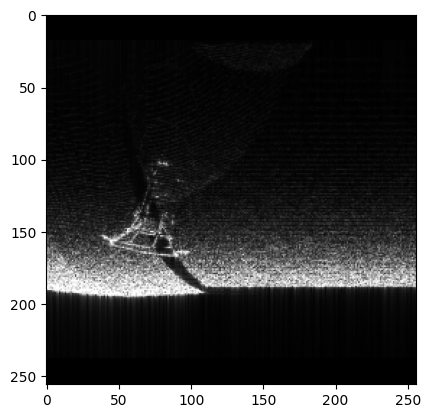

In [46]:
a, min_img, min_gtpose, min_img_path, min_lab_path, b = train_data[467]
plt.imshow(min_img.numpy()[0, :, :], cmap='gray')

In [164]:
## Randomly select an image from the validation dataset
# query_idx = 497
_, min_img, min_gtpose, min_img_path, min_lab_path, _ = train_data.__getitem__(467, True)
print(min_gtpose)
f, axarr = plt.subplots(1, 2, figsize=(15, 15))
axarr[0].imshow(min_img.numpy()[0, :, :], cmap='gray')

plt.scatter(train_data.poses[:train_data.synth, 0], train_data.poses[:train_data.synth, 1], marker='o', linestyle='None', s = 1)
plt.scatter(min_gtpose[0].item(),   min_gtpose[1].item(),   c='blue', s = 20.51, label="database predicted closest pose")
plt.legend(loc="lower right")

ax = plt.gca()
ax.set_xlim([0, train_data.poses[:train_data.synth, 0].max()+50])
ax.set_ylim([0, train_data.poses[:train_data.synth, 1].max()+50])

rad = 50

##### BLUE POINT, PREDICTION FROM THE DATABASE #####
x,y,Y1_deg = min_gtpose
Y1_deg = 90 - Y1_deg
Y1 = Y1_deg * math.pi / 180
dy, dx = rad*math.cos(Y1), rad*math.sin(Y1)
plt.arrow(x, y, dx, dy, color='blue')

center = np.array([x, y]).astype(int)
mask1 = sector_mask((325+50, 295+50),center,50,(Y1_deg-60,Y1_deg+60)).T


##### GREEN POINT, GROUND TRUTH CLOSEST POINT IN THE DATABASE #####
x,y,Y2_deg = train_data.poses[500, :].clone()
Y2_deg = 90 - Y2_deg
Y2 = Y2_deg * math.pi / 180
dy, dx = rad*math.cos(Y2), rad*math.sin(Y2)
plt.arrow(x, y, dx, dy, color='green')

center = np.array([x, y]).astype(int)
mask2 = sector_mask((325+50, 295+50),center,50,(Y2_deg-60,Y2_deg+60)).T

##### INTERFERENCE
mask_and = np.logical_and(mask1, mask2) ## intersection
mask_xor = np.logical_xor(mask1, mask2) ## U/intersection 

R3 = 2*abs(math.cos((Y1-Y2)/2))
mask_and = mask_and*R3

mask3 = mask_and + mask_xor

union = mask1.sum() + mask2.sum()
intersection = mask_and.sum()
iou = intersection/union

print(mask_and.max(), "iou:", iou)

axarr[1].imshow(mask3, cmap="gray")
    
print("localization error: ", np.linalg.norm(train_data.poses[500, :].clone()[:2]-min_gtpose[:2], ord=2), "meters")

TypeError: __getitem__() takes 2 positional arguments but 3 were given

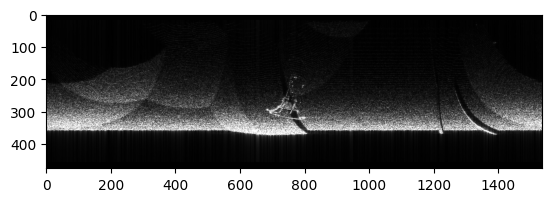

In [175]:
plt.imshow(query_real_image.detach().cpu().numpy()[0, :, :], cmap='gray')

5013
localization error:  187.81046 meters


<Figure size 640x480 with 0 Axes>

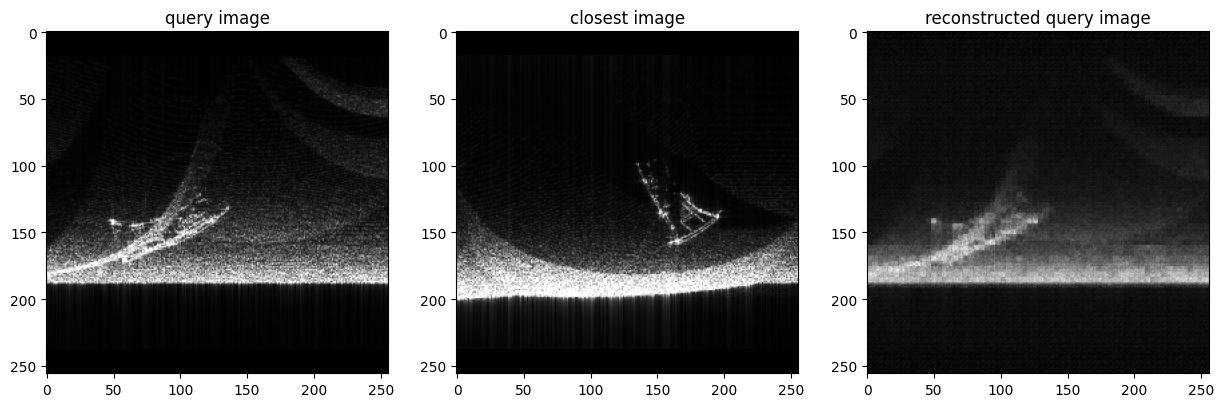

In [364]:
## Randomly select an image from the validation dataset
query_idx = np.random.randint(len(val_data), size=1)[0]

query_input_image, query_real_image, query_gtpose, query_img_path, query_pose_path, _ = val_data[query_idx]
query_input_image = query_input_image[None].cuda()
query_descriptor, (query_reconstructed_image, _, _, _, _)  = net(query_input_image, reco=True)
query_descriptor = query_descriptor.detach().cpu().numpy()
plt.figure()

f, axarr = plt.subplots(1, 3, figsize=(15, 15))

minidx = train_data.query(query_descriptor)
_, min_img, min_gtpose, min_img_path, min_lab_path, _ = train_data[minidx//3]
print(minidx)

axarr[0].set_title("query image")
axarr[1].set_title("closest image")
axarr[2].set_title("reconstructed query image")

axarr[0].imshow(query_real_image.detach().cpu().numpy()[0, :, :], cmap='gray')
axarr[1].imshow(min_img.numpy()[0, :, :], cmap='gray')
axarr[2].imshow(query_reconstructed_image.detach().cpu().numpy()[0, 0, :, :], cmap='gray')

print("localization error: ", np.linalg.norm(query_gtpose[:2]-min_gtpose[:2], ord=2), "meters")

In [65]:
min_dx, min_dy = 335, -458
train_data.poses[:train_data.synth, 0]-=min_dx
train_data.poses[:train_data.synth, 1]-=min_dy
val_data.poses[:, 0]                  -=min_dx
val_data.poses[:, 1]                  -=min_dy
train_data.poses[:train_data.synth, :2]*=10
val_data.poses[:, :2]*=10

In [193]:
train_data.poses[:train_data.synth, 0].max()

tensor(324.3900)

In [12]:
print("Tx", train_data.poses[:train_data.synth, 0].min(), train_data.poses[:train_data.synth, 0].max())
print("Ty", train_data.poses[:train_data.synth, 1].min(), train_data.poses[:train_data.synth, 1].max())
print("Vx", val_data.poses[:, 0].min(), val_data.poses[:, 0].max())
print("Vy", val_data.poses[:, 1].min(), val_data.poses[:, 1].max())

Tx tensor(56.7300) tensor(324.3900)
Ty tensor(52.4100) tensor(294.1400)
Vx tensor(65.1300) tensor(320.1599)
Vy tensor(58.6899) tensor(292.6501)


In [68]:
database.dataset = train_data

In [28]:
# A = np.array([x.item(), y.item()])
# B = np.array([(x+dx).item(), (y+dy).item()])
# C = np.array([x.item(), y.item()])
# D = np.array([(x+dx).item(), (y+dy).item()])

# m = (B[0]-A[0])/(B[1]-A[1])
# q = -m*A[1]+A[0]
# n = (D[0]-C[0])/(D[1]-C[1])
# y = (C[0]-q-n*C[1])/(m-n)
# x = m*y+q
# print("(",A, ") - (", B, ")")
# print("(",C, ") - (", D, ")")
# print(x, y)
# plt.scatter(x,   y,   c='pink', s = 20.51)
CENTER = [194.49, 177.23]
# Y1 = math.atan2((x-CENTER[0]), (y-CENTER[1]))
# Y1 %= 2*np.pi
# Y1_deg = Y1*180/np.pi + 180
# Y1_deg %= 360

In [147]:
del min_gtpose, query_gtpose

In [249]:
query_descriptor2 = torch.nn.functional.normalize(torch.Tensor(query_descriptor), p=2, dim=1)

In [250]:
torch.Tensor(query_descriptor)

tensor([[-0.1532, -0.1360, -0.0933, -0.0700, -0.1527, -0.1359, -0.0933, -0.0699,
         -0.1531, -0.1357, -0.0932, -0.0699, -0.1529, -0.1355, -0.0932, -0.0697,
         -0.1534, -0.1363, -0.0935, -0.0702, -0.1530, -0.1362, -0.0935, -0.0702,
         -0.1532, -0.1363, -0.0936, -0.0702, -0.1529, -0.1361, -0.0934, -0.0701,
         -0.1527, -0.1354, -0.0930, -0.0697, -0.1529, -0.1355, -0.0932, -0.0698,
         -0.1532, -0.1358, -0.0934, -0.0699, -0.1523, -0.1351, -0.0928, -0.0695,
         -0.1526, -0.1357, -0.0932, -0.0699, -0.1533, -0.1359, -0.0933, -0.0699,
         -0.1526, -0.1352, -0.0929, -0.0696, -0.1527, -0.1355, -0.0931, -0.0698,
         -0.1533, -0.1358, -0.0933, -0.0699, -0.1533, -0.1361, -0.0935, -0.0701,
         -0.1532, -0.1359, -0.0933, -0.0700, -0.1530, -0.1358, -0.0933, -0.0699,
         -0.1532, -0.1359, -0.0934, -0.0700, -0.1530, -0.1356, -0.0933, -0.0698,
         -0.1527, -0.1353, -0.0930, -0.0696, -0.1534, -0.1363, -0.0935, -0.0702,
         -0.1528, -0.1358, -

In [255]:
query_descriptor2.std()

tensor(0.0176)

0.0 iou: 0.0
localization error:  92.011505 meters


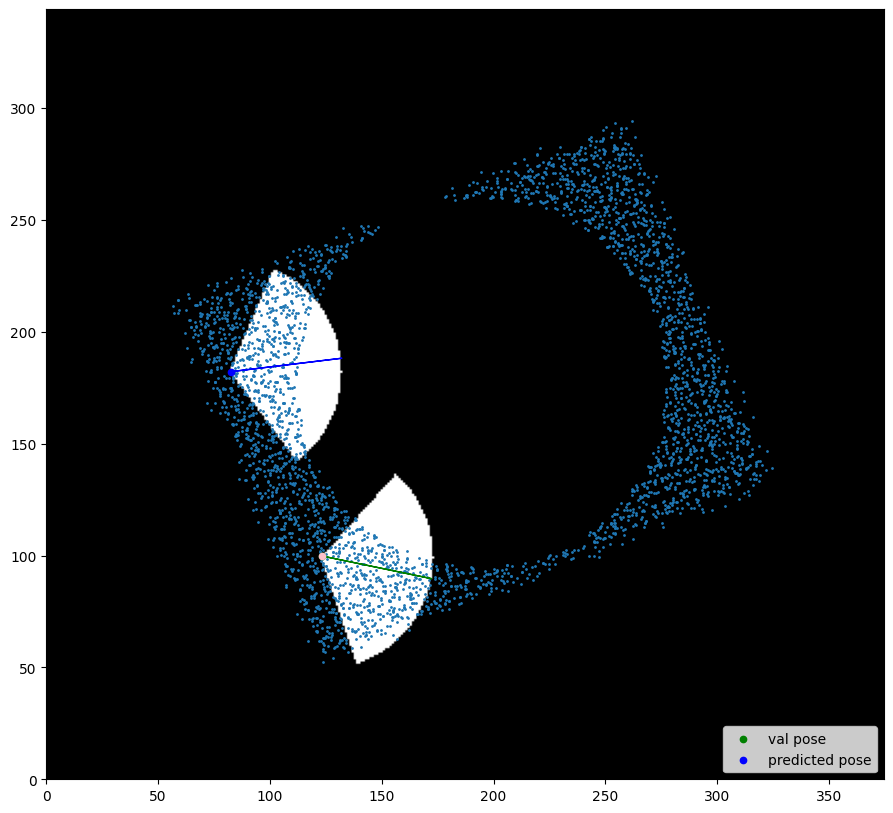

<Figure size 640x480 with 0 Axes>

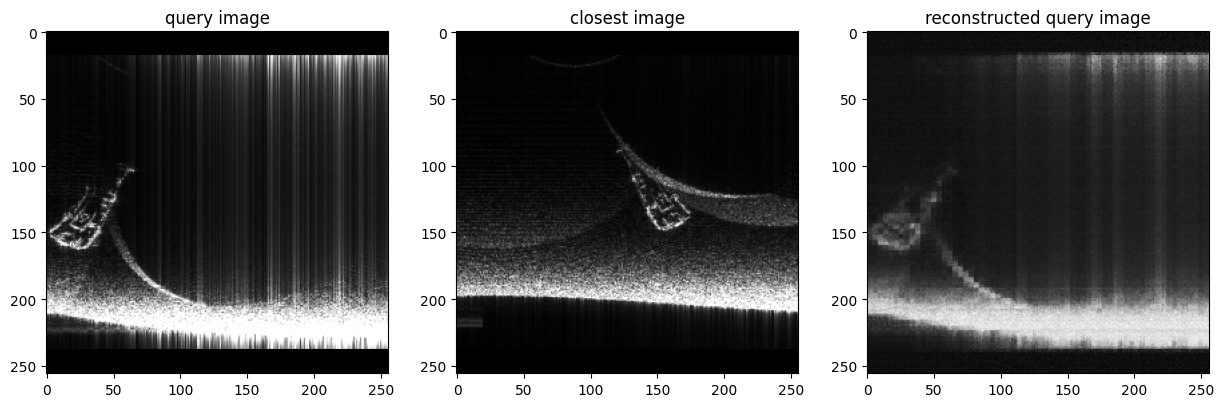

In [368]:
## Randomly select an image from the validation dataset
# query_idx = 497
query_idx = np.random.randint(len(val_data), size=1)[0]
# query_idx = 0

query_input_image, query_real_image, query_pose, query_img_path, query_pose_path, _ = val_data[query_idx]
query_input_image = query_input_image[None].cuda()
query_descriptor, (query_reconstructed_image, _, _, _, _)  = net(query_input_image, reco=True)
query_descriptor = query_descriptor.detach().cpu().numpy()

#minidx, (_, min_img, min_gtpose, min_img_path, min_lab_path, _) = database.query(query_descriptor)
minidx = train_data.query(query_descriptor) //3
_, min_img, min_pose, min_img_path, min_lab_path, _ = train_data[minidx]

# colors = []
# for v in database.norms/database.norms.max():
#     colors.append([v, 0, 0])
plt.figure(figsize = (15,10))    
# plt.scatter(train_data.poses[:train_data.synth, 0], train_data.poses[:train_data.synth, 1], c=colors, marker='o', linestyle='None', s = 1)
plt.scatter(train_data.poses[:train_data.synth, 0], train_data.poses[:train_data.synth, 1], marker='o', linestyle='None', s = 1)

plt.scatter(query_pose[0].item(), query_pose[1].item(), c='green',s = 20.51, label="val pose")
plt.scatter(min_pose[0].item(),   min_pose[1].item(),   c='blue', s = 20.51, label="predicted pose")
plt.legend(loc="lower right")

ax = plt.gca()
ax.set_xlim([0, train_data.poses[:train_data.synth, 0].max()+50])
ax.set_ylim([0, train_data.poses[:train_data.synth, 1].max()+50])

rad = 50

##### BLUE POINT, PREDICTION FROM THE DATABASE #####

x,y,Y1_deg = np.copy(min_pose)
Y1_deg = 90 - Y1_deg
Y1 = Y1_deg * math.pi / 180
dy, dx = rad*math.cos(Y1), rad*math.sin(Y1)
plt.arrow(x, y, dx, dy, color='blue')

center = np.array([x, y]).astype(int)
mask1 = sector_mask((325+50, 295+50),center,50,(Y1_deg-60,Y1_deg+60)).T


##### GREEN POINT, GROUND TRUTH CLOSEST POINT IN THE DATABASE #####
gt_pose = train_data[val_data.closest_indices[query_idx] //3][2]
x,y,Y2_deg = gt_pose
Y2_deg = 90 - Y2_deg
Y2 = Y2_deg * math.pi / 180
dy, dx = rad*math.cos(Y2), rad*math.sin(Y2)
plt.arrow(x, y, dx, dy, color='green')
plt.scatter(x, y,   c='pink', s = 20.51, label="database predicted closest pose")

center = np.array([x, y]).astype(int)
mask2 = sector_mask((325+50, 295+50),center,50,(Y2_deg-60,Y2_deg+60)).T

##### INTERFERENCE
mask_and = np.logical_and(mask1, mask2) ## intersection
mask_xor = np.logical_xor(mask1, mask2) ## U/intersection 

R3 = 2*abs(math.cos((Y1-Y2)/2))
mask_and = mask_and*R3

mask3 = mask_and + mask_xor

union = mask1.sum() + mask2.sum()
intersection = mask_and.sum()
iou = intersection/union if union>0 else 0

print(mask_and.max(), "iou:", iou)

plt.imshow(mask3, cmap="gray")

plt.figure()

f, axarr = plt.subplots(1, 3, figsize=(15, 15))
axarr[0].set_title("query image")
axarr[1].set_title("closest image")
axarr[2].set_title("reconstructed query image")

axarr[0].imshow(query_real_image.detach().cpu().numpy()[0, :, :], cmap='gray')
axarr[1].imshow(min_img.numpy()[0, :, :], cmap='gray')
axarr[2].imshow(query_reconstructed_image.detach().cpu().numpy()[0, 0, :, :], cmap='gray')

print("localization error: ", np.linalg.norm(query_pose[:2]-min_pose[:2], ord=2), "meters")


In [ ]:
194.48681953870533 177.22928917134055

In [11]:
def sector_mask(shape,centre,radius,angle_range):
    """
    Return a boolean mask for a circular sector. The start/stop angles in  
    `angle_range` should be given in clockwise order.
    """

    x,y = np.ogrid[:shape[0],:shape[1]]
    cx,cy = centre
    tmin,tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)

    # circular mask
    circmask = r2 <= radius*radius

    # angular mask
    anglemask = theta <= (tmax-tmin)

    # theta -= np.pi/3
    # theta %= (2*np.pi)

    return (circmask*anglemask).astype(int)#*theta

[292 200]
(375, 1)
(375, 1)
(1, 345)
(1, 345)
(375, 345)
(375, 345)


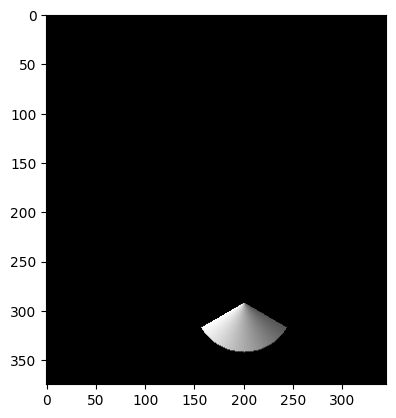

In [199]:
center = min_gtpose[:2].numpy().astype(int).T
print(center)
# center+=50
# print(center)

mask = sector_mask((325+50, 295+50),center,50,(30,150))

# mask = np.flip(mask, 0)
# mask = np.flip(mask, 1)

plt.imshow(mask, cmap="gray")

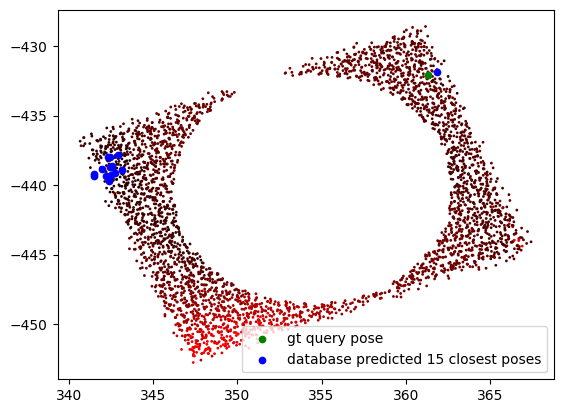

<Figure size 640x480 with 0 Axes>

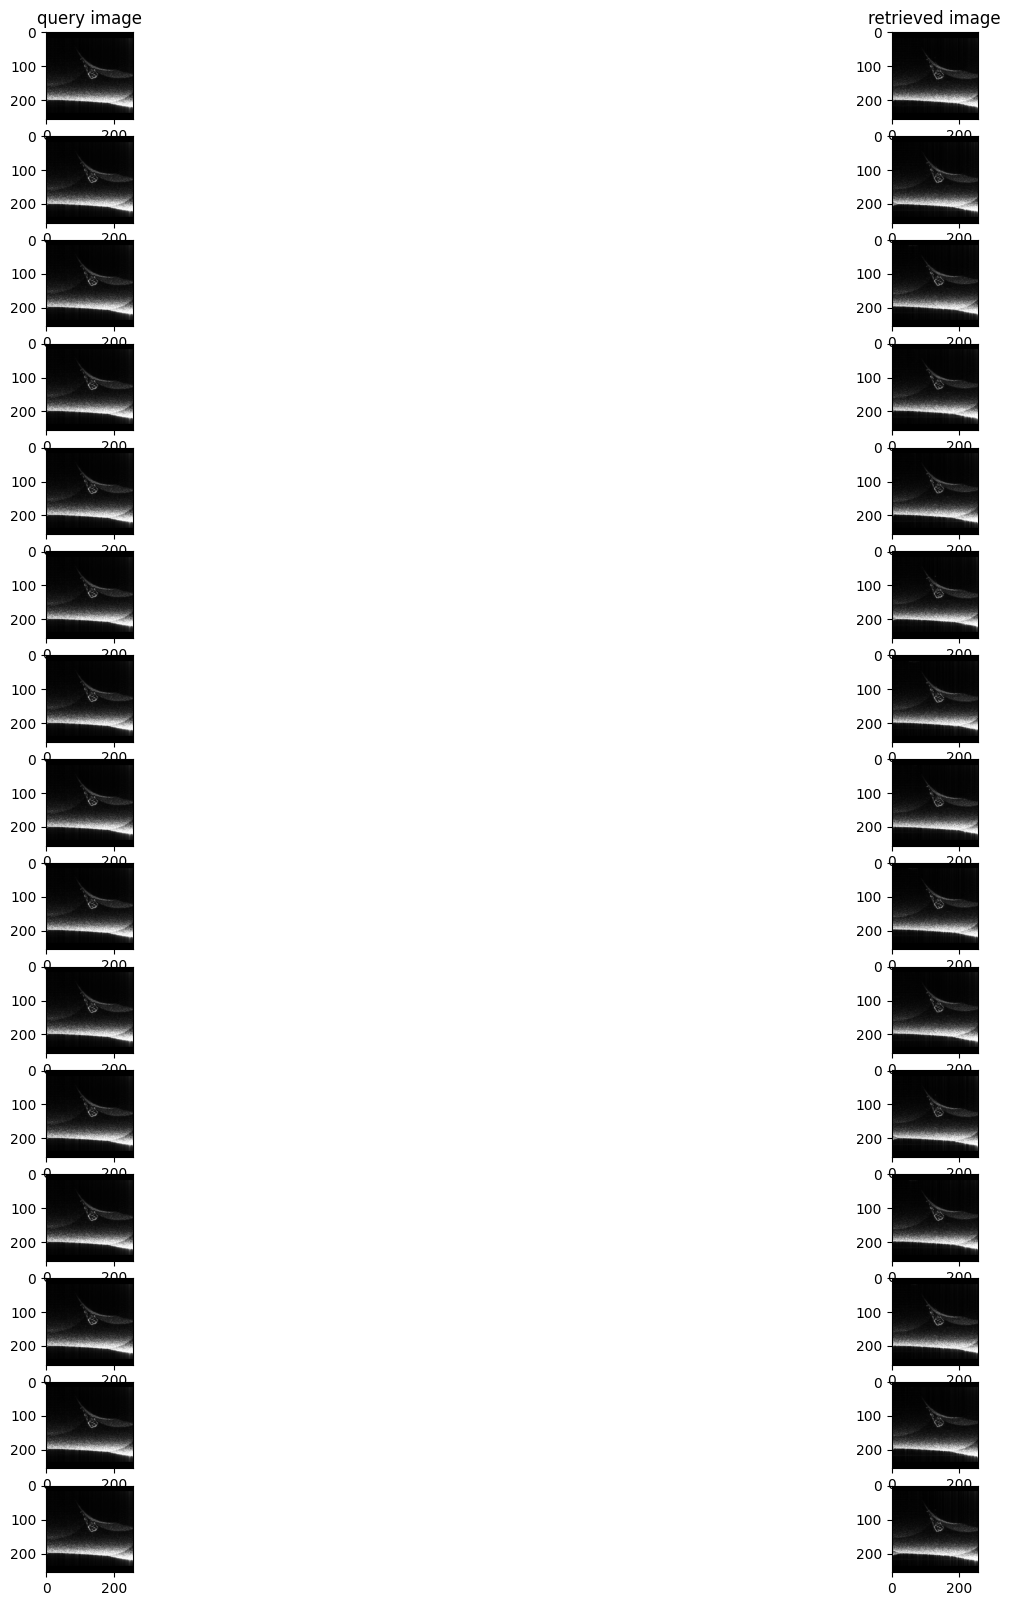

In [111]:
K = 15
bests = database.norms.argsort()
# bestpos = np.zeros((3, 2))
# totw=0

preds = np.zeros((K, 2))
imgs = []
for i in range(K):
    _, img, minpos, _, _, _ = database.dataset[bests[i]]
    preds[i, :] = minpos[:2]
    imgs.append(img)

# px = bestpos[:, 0].sum()/totw
# py = bestpos[:, 1].sum()/totw
# bestw = np.array([px, py])

# _, _, best, _, _ = test_data[bests[0]]

# print("localization error w: ", np.linalg.norm(lab[:2]-bestw, ord=2))
# print("localization error b: ", np.linalg.norm(lab[:2]-best[:2], ord=2))

colors = []
for v in database.norms/database.norms.max():
    colors.append([v, 0, 0])
    
plt.scatter(train_data.poses[:train_data.synth, 0], train_data.poses[:train_data.synth, 1], c=colors, marker='o', linestyle='None', s = 1)
plt.scatter(query_gtpose[0].item(), query_gtpose[1].item(), c='green',s = 20.51, label="gt query pose")
plt.scatter(preds[:, 0], preds[:, 1], c='blue', s = 20.51, label=f"database predicted {K} closest poses")
plt.legend(loc="lower right")


plt.figure()

f, axarr = plt.subplots(K, 2, figsize=(20, 20))

axarr[0,0].set_title(f"query image")
axarr[0,1].set_title(f"retrieved image")


for i in range(K):

    axarr[i,0].imshow(query_real_image.detach().cpu().numpy()[0, :, :], cmap='gray')
    axarr[i,1].imshow(imgs[i].numpy()[0, :, :], cmap='gray')


In [101]:
val_pred_embeds = torch.zeros((len(val_data), emb_size))
for idx in tqdm(range(len(val_data))):
    image, _, _, _, _, _ = val_data[idx]
    image = image[None].cuda()
    descriptor = net(image, reco=False)[0, :].detach().cpu()
    val_pred_embeds[idx] = descriptor

# pred_indices = correlate_poses(val_pred_embeds, train_pred_embeds)
gt_indices = val_data.closest_poses

# acc = torch.sum(pred_indices == gt_indices).item() / pred_indices.numel()
# print(acc)



 17%|██████▉                                  | 103/609 [00:02<00:12, 39.41it/s]


KeyboardInterrupt: 

In [73]:
pred_indices      = correlate_poses_topk(val_pred_embeds, torch.Tensor(database.descriptors), k=1).squeeze()
pred_indices_top5 = correlate_poses_topk(val_pred_embeds, torch.Tensor(database.descriptors), k=5)

avg_metric_e      = computeAverageMetricError(pred_indices,      gt_indices, train_data, k=1)
avg_metric_e_top5 = computeAverageMetricError(pred_indices_top5, gt_indices, train_data, k=5)

print("avg_metric_e     :", avg_metric_e)
print("avg_metric_e_top5:", avg_metric_e_top5)

/tmp/ipykernel_1911319/4003206513.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  pred_indices      = correlate_poses_topk(val_pred_embeds, torch.Tensor(database.descriptors), k=1).squeeze()


tensor(21.7005)
tensor(21.7026)
avg_metric_e     : tensor(4.3224)
avg_metric_e_top5: tensor(2.4566)
